# Experiments

This notebook contains all the experiments we ran to generate the data presented in the report, plus some extra.

Check out `./alg.py` for implementation of the specific algorithms.

In [1]:
%load_ext autoreload

In [2]:
%autoreload
import utils 
import alg 
import numpy as np 
import pandas as pd 
import tqdm
import matplotlib.pyplot as plt 

## Weiszfeld Algorithm

### On randomized problem

Found solution f(A[5]) = f(-0.432, 0.212) = 3.903


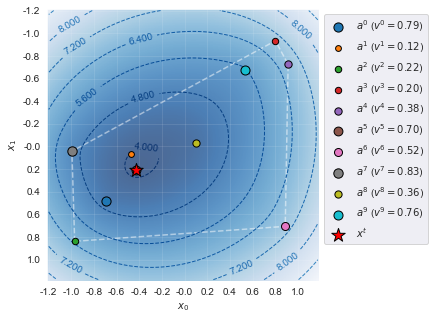

In [128]:
seed = 12 #666
problem = utils.Problem.generate(10, seed=seed, objective=alg.objective)
# problem = utils.Problem.premade('five', objective=alg.objective) # A[4] is the solution
# problem = utils.Problem.premade('equilateral', objective=alg.objective)

A, v = problem.A, problem.v
initial_solution = alg.check_initial_solution(A, v)
if initial_solution:
    k, a, f_a = initial_solution
    print(f'Found solution f(A[{k}]) = f({a[0] :.3f}, {a[1] :.3f}) = {f_a :.3f}')
    history = np.array([a])
else:
    x0 = alg.initialize_bbox(A, v, seed=seed)
    criterion = alg.stopping_criterion_1(A, v, epsilon=1e-3)  # Within 0.1% of best solution
    history = alg.weiszfeld(A, v, x0, criterion)
    print(f'Total steps: {len(history)}')
    print(f'Final iterate: f({history.x0.iloc[-1] :.3f}, {history.x1.iloc[-1] :.3f}) = {history.f_x.iloc[-1] :.3f}')
    
problem.plot_2d(iterates=history, figsize=(6, 5));

### A few more examples

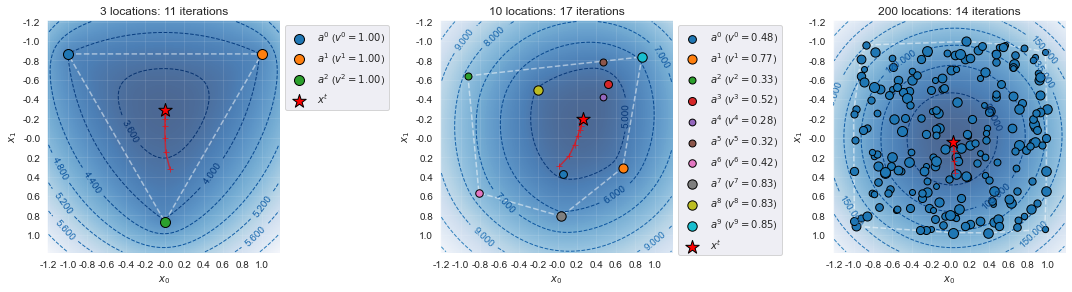

In [129]:
seed = 222
criterion = alg.stopping_criterion_1
initializer = alg.initialize_bbox
epsilon = 1e-3
problems = [
#     utils.Problem.premade('rectangle', objective=alg.objective),
    utils.Problem.premade('equilateral', objective=alg.objective),
    utils.Problem.generate(10, seed=seed, objective=alg.objective),
    utils.Problem.generate(200, seed=seed, objective=alg.objective),
]
fig, axes = plt.subplots(figsize=(5 * len(problems), 5), ncols=len(problems))
for problem, ax in zip(problems, np.array(axes).ravel()):
    A, v = problem.A, problem.v
    history = alg.weiszfeld(A, v, initializer(A, v, seed=seed), criterion(A, v, epsilon=epsilon))
    problem.plot_2d(iterates=history, ax=ax)
    ax.set_title(f'{problem.title}: {len(history)} iterations')
fig.tight_layout()
plt.savefig('data/weiszfeld_samples.pdf')

### Initial solutions

Here we look at the fraction of problems where one of the $a^k$ is the solution. Clearly, it is quite common for problems with fewer locations, but it gets increasingly rare for problems with more locations.

100%|██████████| 1000/1000 [04:22<00:00,  3.81it/s]


10      0.137
100     0.014
1000    0.000
dtype: float64

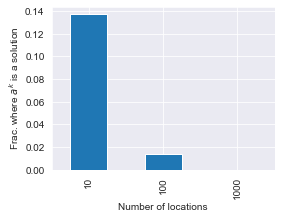

In [130]:
def count_initial_solutions(m, runs):
    count = []
    for seed in tqdm.tqdm(range(runs)):
        problem = utils.Problem.generate(m, seed=seed, objective=alg.objective)
        A, v = problem.A, problem.v
        count.append(int(alg.check_initial_solution(A, v) is not None))
    return pd.Series(count)

counts = pd.DataFrame()
for m in [10, 100, 1000]:
    counts[m] = count_initial_solutions(m, 1000)
ax = counts.mean().plot.bar(figsize=(4, 3))
ax.set_ylabel('Frac. where $a^k$ is a solution')
ax.set_xlabel('Number of locations')
plt.savefig('data/initial_solution.pdf')
counts.mean()

## Evaluate Termination Criterions

Here we compare the two proposed evaluation criteria. For different values of $\epsilon$, we measure how many extra/unnecessary iterates that are generated until the bounds catch up with the value they are trying to bound. 

100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


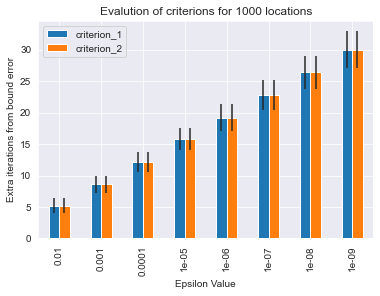

In [131]:
m = 1000
data_1 = []
data_2 = []
for seed in tqdm.tqdm(range(100)):
    problem = utils.Problem.generate(m, seed=seed, objective=alg.objective)
    A, v = problem.A, problem.v
    x0 = alg.initialize_com(A, v, seed=seed)
    history = alg.weiszfeld(A, v, x0)
    
    f_x = history.f_x 
    assert abs(f_x.iloc[-2] - f_x.iloc[-1]) < 1e-10
    x_opt = history[['x0', 'x1']].iloc[-1]
    f_opt = f_x.iloc[-1]  # Assume last f is optimal 

    rel_acc_1 = (f_x - f_opt).abs() / f_opt
    rel_acc_2 = (f_x - f_opt).abs() / f_x

    ub = pd.Series([alg.objective_upper_bound(A, v, x) for x in history[['x0', 'x1']].values])
    lb = f_x - ub 

    criterion_1 = ub / lb.where(lb > 0, np.nan)
    criterion_2 = ub / f_x 
    
    # Check that criterion is always a valid upper bound
    assert ((lb <= 0) | (criterion_1 >= rel_acc_1)).all()
    assert (criterion_2 >= rel_acc_2).all()

    row_1 = {}
    row_2 = {}

    for epsilon in [10**(-i) for i in range(2, 10)]:

        idx_1 = (rel_acc_1 <= epsilon).idxmax()
        idx_2 = (rel_acc_2 <= epsilon).idxmax()

        idx_c1 = (criterion_1 < epsilon).idxmax()
        idx_c2 = (criterion_2 < epsilon).idxmax()
        
        row_1[epsilon] = idx_c1
        row_2[epsilon] = idx_c2
    
    data_1.append(row_1)
    data_2.append(row_2)
    
data_1 = pd.DataFrame(data_1)
data_2 = pd.DataFrame(data_2)
means = pd.DataFrame(dict(criterion_1=data_1.mean(), criterion_2=data_2.mean()))
stds = pd.DataFrame(dict(criterion_1=data_1.std(), criterion_2=data_2.std()))
ax = means.plot.bar(yerr=stds)
ax.set_title(f'Evalution of criterions for {problem.title}')
ax.set_ylabel('Extra iterations from bound error')
ax.set_xlabel('Epsilon Value');
plt.savefig('data/criterion_evaluation.pdf')

## Gradient Descent

### Basic Example

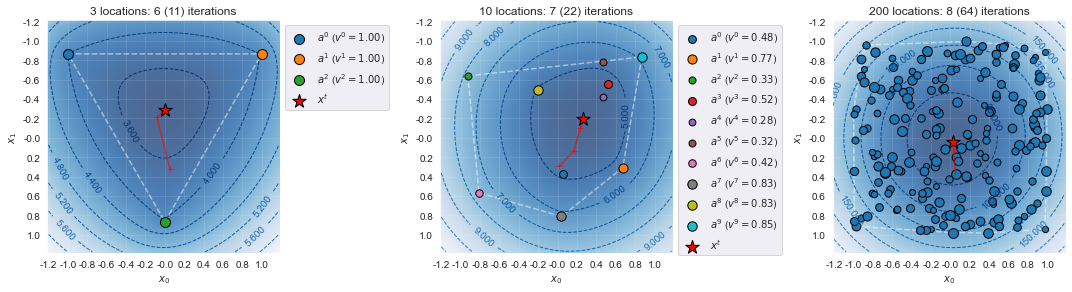

In [132]:
seed = 222
initializer = alg.initialize_bbox
criterion = alg.stopping_criterion_1
epsilon = 1e-3
alpha = 1.0
rho = 0.5
c = 0.5
problems = [
    utils.Problem.premade('equilateral', objective=alg.objective),
    utils.Problem.generate(10, seed=seed, objective=alg.objective),
    utils.Problem.generate(200, seed=seed, objective=alg.objective),
]
fig, axes = plt.subplots(figsize=(5 * len(problems),5), ncols=len(problems))
for problem, ax in zip(problems, np.array(axes).ravel()):
    A, v = problem.A, problem.v
    history = alg.gradient_descent(
        A, v, initializer(A, v, seed=seed), criterion(A, v, epsilon=epsilon),
        alpha=alpha, rho=rho, c=c
    )
    problem.plot_2d(iterates=history, ax=ax)
    ax.set_title(f'{problem.title}: {len(history)} ({history.steps.sum()}) iterations')
fig.tight_layout()
plt.savefig('data/gradient_descent_samples.pdf')

### Tune Hyperparameters

Gradient descent with backtracking line search didn't work great with our arbitrary choices of ($\bar{\alpha}, \rho, c$). Consequently, we run a sweep for each choice of $|A|$ (m), using the optuna package with the TPE algorithm. 

In [3]:
import optuna


def number_of_backtracks(trial, m):
    initializer = alg.initialize_com
    criterion = alg.stopping_criterion_1
    epsilon = 1e-3

    alpha = trial.suggest_loguniform('alpha', 0.1, 10)
    rho = trial.suggest_uniform('rho', 0.05, 0.95)
    c = trial.suggest_uniform('c', 0.05, 0.95)
    
    seed = 0
    total = []
    for i in range(100):
        while True:
            seed += 1
            problem = utils.Problem.generate(m, seed=seed, objective=alg.objective)
            A, v = problem.A, problem.v
            if not alg.check_initial_solution(A, v):
                break
        history = alg.gradient_descent(
            A, v, initializer(A, v, seed=seed), criterion(A, v, epsilon=epsilon),
            alpha=alpha, rho=rho, c=c, max_iters=100,
        )
        total.append(history.steps.sum())  # Minimize total calls to objective function 
    return np.mean(total)


best_params = {}
for m in [10, 100, 1000]:
    optuna.logging.set_verbosity(30)
    study = optuna.create_study()
    n_trials = 100
    with tqdm.tqdm(total=n_trials) as pbar:
        def f(trial):
            pbar.update(1)
            return number_of_backtracks(trial, m)
        study.optimize(f, n_trials=n_trials)
    best_params[m] = study.best_params
best_params

 11%|█         | 11/100 [00:08<01:24,  1.06it/s]/Users/sverre/Projects/courses/tma4180/project/alg.py:214: UserWarning: Gradient descent did not terminate!
  warnings.warn('Gradient descent did not terminate!')
100%|██████████| 100/100 [42:56<00:00, 25.77s/it]


{10: {'alpha': 0.15818354663571943,
  'rho': 0.4408180554755787,
  'c': 0.3115448845290894},
 100: {'alpha': 0.1022341506839723,
  'rho': 0.1816379305283983,
  'c': 0.0814066661672439},
 1000: {'alpha': 0.5423614488714905,
  'rho': 0.1573427228165088,
  'c': 0.27978198771268137}}

## Grand comparison

Here we compare the Weiszfeld algorithm and backtracking line search. For line search we compare both the one with naive hyperparameters and one with optimized hyperparameters.

In [18]:
DATA = {}

In [46]:
initializer = alg.initialize_com
criterion = alg.stopping_criterion_1
epsilon = 1e-4
alpha = 1.0
rho = 0.5
c = 0.5
ms = [10, 100, 1000]

def evaluate(m, runs):
    num_iterates = []
    num_steps = []
    seed = 0
    for _ in tqdm.tqdm(range(runs)):
        
        # Find next problem where a^k is not a solution
        while True:
            seed += 1
            problem = utils.Problem.generate(m, seed=seed, objective=alg.objective)
            
            A, v = problem.A, problem.v
            if not alg.check_initial_solution(A, v):
                break
    
        x0 = initializer(A, v, seed=seed)
        history_wf = alg.weiszfeld(A, v, x0, criterion(A, v, epsilon=epsilon))
        history_gd = alg.gradient_descent(A, v, x0, criterion(A, v, epsilon=epsilon), alpha=alpha, rho=rho, c=c)
        alpha_opt, rho_opt, c_opt = best_params[m]['alpha'], best_params[m]['rho'], best_params[m]['c']
        history_gd_opt = alg.gradient_descent(A, v, x0, criterion(A, v, epsilon=epsilon), alpha=alpha_opt, rho=rho_opt, c=c_opt)
        
        num_iterates.append({
            'Weiszfeld': len(history_wf),
            'Grad. Desc.': len(history_gd),
            'Grad. Desc. Opt.': len(history_gd_opt),
        })
        num_steps.append({
            'Weiszfeld': len(history_wf),
            'Grad. Desc.': history_gd.steps.sum(),
            'Grad. Desc. Opt.': history_gd_opt.steps.sum(),
        })
    return pd.concat(
        [pd.DataFrame(num_iterates), pd.DataFrame(num_steps)],
        axis=1, keys=['num_iterates', 'num_steps']
    )

for m in ms:
    DATA[(epsilon, m)] = evaluate(m, 1000)

 22%|██▎       | 225/1000 [00:04<00:15, 49.05it/s]/Users/sverre/Projects/courses/tma4180/project/alg.py:151: UserWarning: Weiszfeld algorithm did not terminate!
  warnings.warn('Weiszfeld algorithm did not terminate!')
100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]


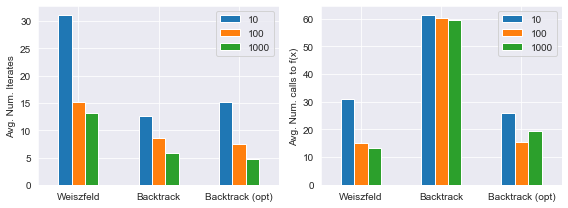

In [61]:
epsilon = 1e-4
all_means = pd.DataFrame()
all_stds = pd.DataFrame()
y_err = False 
for m in ms:
    all_means[m] = DATA[epsilon, m].mean()
    all_stds[m] = DATA[epsilon, m].std()

plotname = 'data/comparison_1em3.pdf'
fig, (ax1, ax2) = plt.subplots(figsize=(8, 3), ncols=2)
all_means.loc['num_iterates'].plot.bar(ax=ax1, yerr=all_stds.loc['num_iterates'] if y_err else None)
ax1.set_ylabel('Avg. Num. Iterates')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)
all_means.loc['num_steps'].plot.bar(ax=ax2, yerr=all_stds.loc['num_steps'] if y_err else None)
ax2.set_ylabel('Avg. Num. calls to f(x)');
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0)
fig.tight_layout()
plt.savefig(f'data/comparison_{epsilon}{"_std" if y_err else ""}.pdf')

## Extra - Geometric Interpretation of 2.2

Here we generate a plot to visualize the geometric interpretation of solving the max problem with euclidean distance. 
Since we're not trying to solve it, the problem is generated backward from a solution.

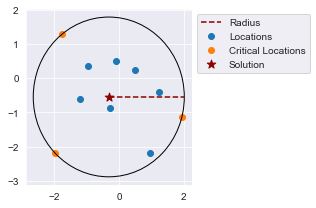

In [121]:
# edge_angles = np.random.uniform(0, 2*np.pi, size=3)
# edge_radius = 2.34
# edge_points = edge_radius * np.stack([np.cos(edge_angles), np.sin(edge_angles)], axis=-1)
# extra_angles = np.random.uniform(0, 2*np.pi, size=7)
# extra_radii = np.random.uniform(0.1 * edge_radius, 0.9 * edge_radius, size=len(extra_angles))
# extra_points = extra_radii[:,None] * np.stack([np.cos(extra_angles), np.sin(extra_angles)], axis=-1)

# offset = np.random.normal(size=2)
# edge_points += offset 
# extra_points += offset

fig, ax = plt.subplots(figsize=(4.5, 3))
ax.scatter(extra_points[:,0], extra_points[:,1], label='Locations')
ax.scatter(edge_points[:,0], edge_points[:,1], label='Critical Locations')
ax.scatter([offset[0]], [offset[1]], marker='*', s=80, color='darkred', label='Solution')
ax.plot([offset[0], offset[0] + edge_radius], [offset[1], offset[1]], '--', color='darkred', label='Radius')
ax.add_patch(plt.Circle(offset, edge_radius, color='black', fill=False))
ax.set_xlim(offset[0] - edge_radius * 1.1, offset[0] + edge_radius * 1.1)
ax.set_ylim(offset[1] - edge_radius * 1.1, offset[1] + edge_radius * 1.1)
ax.legend(bbox_to_anchor=(1,1));
fig.tight_layout()
plt.savefig('data/geometric_interpretation.pdf')